# Feature Selection & Cleaning Pipeline

Scope:
- Load an EEG features superset and prepare a features subset suitable for ML training or prediction
- For an entire EEG study with multiple sibjects
- Using Scikit-Learn transformers and pipeline for a repeatable process

The Pipeline Stages:
- TBD


## Dependencies

General dependencies:
- python = 3.11.13
- numpy = 2.0.2
- scipy = 1.15.3
- pandas = 2.2.3
- matplotlib = 3.10.3

ML dependencies:
- scikit-learn = 1.6.1



# Imports & Utilities

In [1]:
# General imports
import os
import gc
from datetime import datetime
from pprint import pprint
import time
import pickle

import math
import numpy as np
import pandas as pd

# Plots
import matplotlib.pyplot as plt
plt.style.use('ggplot')

# ML
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, OneHotEncoder

from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay


In [2]:
# Utility function to establish relative paths for a given folder
def get_folder_path(folder_name, data_folder='Data'):
    project_root = os.path.dirname(os.getcwd())
    folder_path = os.path.join(project_root, data_folder, folder_name)
    if not os.path.isdir(folder_path):
        raise FileNotFoundError(f'Directory not found: {folder_path}')  
    return folder_path

# Utility function to create a new folder path, if not exists
def make_folder_path(folder_name, data_folder='Data', exists_ok=True):
    project_root = os.path.dirname(os.getcwd())
    folder_path = os.path.join(project_root, data_folder, folder_name)
    if os.path.exists(folder_path):
        if not exists_ok:
            raise FileExistsError(f"Directory already exists: {folder_path}")
    else:
        os.makedirs(folder_path)
    return folder_path

 # Utility function to extend an existing folder path with a subfolder
def extend_folder_path(base_folder, subfolder, exists_ok=True):
    if not os.path.isdir(base_folder):
        raise FileNotFoundError(f'Parent directory not found: {base_folder}')
    extended_path = os.path.join(base_folder, subfolder)
    if os.path.exists(extended_path):
        if not exists_ok:
            raise FileExistsError(f"Directory already exists: {extended_path}")
    else:
        os.makedirs(extended_path)
    return extended_path

# Utility function to check for the existence of a file in a given folder
def get_file_path(folder, file_name):
    file_path = os.path.join(folder, file_name)
    if not os.path.isfile(file_path):
        raise FileNotFoundError(f'File not found: {file_path}')
    return file_path


# Classes & Functions

## Features Inspection

In [3]:
# Features Summary & plots

# def features_inspection(features_df):


In [4]:
# Plots for subject info
def subject_info_plot(features_df):

    fig, axes = plt.subplots(1, 3, figsize=(16, 6))

    # PD histogram
    axes[0].hist(features_df['pd'].dropna(), bins=3, color='skyblue', edgecolor='black')
    axes[0].set_title('PD')
    axes[0].set_xlabel('PD')
    axes[0].set_ylabel('Count')

    # Gender histogram
    axes[1].hist(features_df['gender'].map({'M': 0, 'F': 1}), bins=2, color='lightgreen', edgecolor='black', rwidth=0.8)
    axes[1].set_title('Gender (0=M, 1=F)')
    axes[1].set_xlabel('Gender')
    axes[1].set_ylabel('Count')
    axes[1].set_xticks([0, 1])
    axes[1].set_xticklabels(['M', 'F'])

    # Age boxplot
    axes[2].boxplot(features_df['age'].dropna())
    axes[2].set_title('Age')
    axes[2].set_ylabel('Age')
    axes[2].set_xticks([1])
    axes[2].set_xticklabels(['Subjects'])

    plt.tight_layout()
    plt.show()


In [5]:
# Summary of channels
def channels_check(features_df, expected_channels = 63):

    from collections import Counter

     # Get the max number of channels all subjects
    chn_cols = [col for col in features_df.columns if col.startswith('chn_')]
    chn_numbers = set([col.split('_')[1] for col in chn_cols if col.split('_')[1].isdigit()])
    num_channels = len(chn_numbers)

    # Get the number of channels with periodic components
    exponent_cols = [col for col in chn_cols if col.endswith('exponent')]
    # num_exp_channels = len(exponent_cols)
    summary = []
    for idx, row in features_df.iterrows():
        subject_id = row['subject_id']

        # Channels With Peaks & difference with expected
        exponents = row[exponent_cols].dropna().values
        num_channels = len(exponents)
        chann_diff = num_channels - expected_channels
        if chann_diff != 0:
            summary.append({
                'subject_id': row['subject_id'],
                'aperiodic_diff': chann_diff,
                })
            
    # Count how many subjects have each unique channel difference
    diff_counts = Counter([entry['aperiodic_diff'] for entry in summary])

    print(f'Expected Channels: {expected_channels}. Subjects Differing: {len(summary)}')
    print("Subjects per channel difference:", dict(diff_counts))
    # print(pd.DataFrame(summary))
    

In [6]:
# Box plot of aperiodic components
def aperiodic_components_plot(features_df):

    # Extract all columns for offset and exponent & stack
    offset_cols = [col for col in features_df.columns if col.endswith('_offset')]
    exponent_cols = [col for col in features_df.columns if col.endswith('_exponent')]
    offset_values = features_df[offset_cols].values.flatten()
    exponent_values = features_df[exponent_cols].values.flatten()

    # Remove NaNs
    offset_values = offset_values[~np.isnan(offset_values)]
    exponent_values = exponent_values[~np.isnan(exponent_values)]

    # Box plots
    fig, axes = plt.subplots(1, 2, figsize=(12, 8))
    fig.suptitle('Aperiodic Features Distribution Across Subjects')

    axes[0].boxplot(offset_values)
    # axes[0].set_ylabel('Offset Value')
    axes[0].set_xticks([1])
    axes[0].set_xticklabels(['Offset'], fontsize=12)

    axes[1].boxplot(exponent_values)
    # axes[1].set_ylabel('Exponent Value')
    axes[1].set_xticks([1])
    axes[1].set_xticklabels(['Exponent'])

    plt.tight_layout()
    plt.show()

In [7]:
# Box plot of periodic components
def periodic_components_plot(features_df):
    
    # Extract all columns for cf, pw, bw & stack
    cf_cols = [col for col in features_df.columns if '_cf_' in col]
    pw_cols = [col for col in features_df.columns if '_pw_' in col]
    bw_cols = [col for col in features_df.columns if '_bw_' in col]

    cf_values = features_df[cf_cols].values.flatten()
    cf_values = cf_values[~np.isnan(cf_values)]
    pw_values = features_df[pw_cols].values.flatten()
    pw_values = pw_values[~np.isnan(pw_values)]
    bw_values = features_df[bw_cols].values.flatten()
    bw_values = bw_values[~np.isnan(bw_values)]

    # Bosplots
    fig, axes = plt.subplots(1, 3, figsize=(18, 8))
    fig.suptitle('Periodic Features Distribution Across Subjects', fontsize=16)

    axes[0].boxplot(cf_values)
    # axes[0].set_ylabel('CF Value')
    axes[0].set_xticks([1])
    axes[0].set_xticklabels(['CF'])

    axes[1].boxplot(pw_values)
    # axes[1].set_ylabel('PW Value')
    axes[1].set_xticks([1])
    axes[1].set_xticklabels(['PW'])

    axes[2].boxplot(bw_values)
    # axes[2].set_ylabel('BW Value')
    axes[2].set_xticks([1])
    axes[2].set_xticklabels(['BW'])

    plt.tight_layout()

In [8]:
# Box plot of fit measures
def fit_error_plot(features_df):

    # Collect all r_squared and error columns & stack
    r2_cols = [col for col in features_df.columns if col.endswith('r_squared')]
    error_cols = [col for col in features_df.columns if col.endswith('error')]
    r2_values = features_df[r2_cols].values.flatten()
    r2_values = r2_values[~np.isnan(r2_values)]
    error_values = features_df[error_cols].values.flatten()
    error_values = error_values[~np.isnan(error_values)]

    # Plot
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    fig.suptitle('Fit Measures Distributions Across Subjects')

    axes[0].boxplot(r2_values)
    # axes[0].set_title('r_squared')
    # axes[0].set_ylabel('Value')
    axes[0].set_xticks([1])
    axes[0].set_xticklabels(['r_squared'])

    axes[1].boxplot(error_values)
    # axes[1].set_title('error')
    # axes[1].set_ylabel('Value')
    axes[1].set_xticks([1])
    axes[1].set_xticklabels(['error'])

    plt.tight_layout()
    plt.show()

# Run Full Pipeline

Stages TODO

- Features Superset Load
- ?? Feature Extraction ... Initial Subset of Features
- ?? Do any analysis, information gain analysis etc ... or run models and iterate
- Features Cleaning
- Data Split - X,y
- Transformation X

## Setup Parameters etc

In [9]:
# ML Features Pipeline Run Define & Setup
#

# -----------------------------------------------------------------------
# Study Details
study_name = 'IOWA_Rest'
dataset_ref = 'ds004584-1.0.0'
eeg_run_folder = 'EEG_Processing_ds004584-1.0.0_20250619_no_preprocess'
# study_name = 'UNM_Oddball'
# dataset_ref = 'ds003490-1.1.0'
# eeg_run_id = '20250618'

# Run/Test Mode
test_mode = False

# Execution Parameters
run_summary = 'skeleton_run'
ml_params = {'models': 'none'
            }
# -----------------------------------------------------------------------

# Get existing study details, if exists
study_folder_path = get_folder_path('Study_' + study_name)
study_info_df = pd.read_pickle(study_folder_path + '/study_inf_df.pkl', compression='zip')
study_subjects_df = pd.read_pickle(study_folder_path + '/study_subjects_df.pkl', compression='zip')

# Get all folder paths from study_info_df
eeg_processing_results_path = study_info_df.loc[0, 'eeg_processing_results_path']
ml_training_results_path = study_info_df.loc[0, 'ml_training_results_path']

# Get EEG results files
eeg_results_run_path = os.path.join(eeg_processing_results_path, eeg_run_folder)
if not os.path.isdir(eeg_results_run_path):
    raise FileNotFoundError(f'Directory not found: {eeg_results_run_path}')
eeg_features_superset_file_path = get_file_path(eeg_results_run_path, 'eeg_results_features_superset_df.pkl')
eeg_run_parameters_file_path = get_file_path(eeg_results_run_path, 'eeg_run_params_df.pkl')

# Establish a new ML Training Run
current_date = datetime.now().strftime('%Y%m%d')
ml_run_id = f'ML_Training_{dataset_ref}_{current_date}_{run_summary}'
ml_training_run_path = extend_folder_path(ml_training_results_path, ml_run_id, exists_ok=False)

# Create run df and save
ml_run_params_df = pd.DataFrame({
    'ml_run_id': [ml_run_id],
    'study_name': [study_name],
    'dataset_ref': [dataset_ref],
    'ml_params': [ml_params]
})
ml_run_params_df.to_pickle(ml_training_run_path + '/ml_run_params_df.pkl', compression='zip')

# Set progress messages, testing
if test_mode:
    VERBOSE = True
else:
    VERBOSE = False

del current_date, eeg_processing_results_path, eeg_run_folder, eeg_results_run_path, ml_training_results_path, run_summary

## Features Superset Load & Inspection

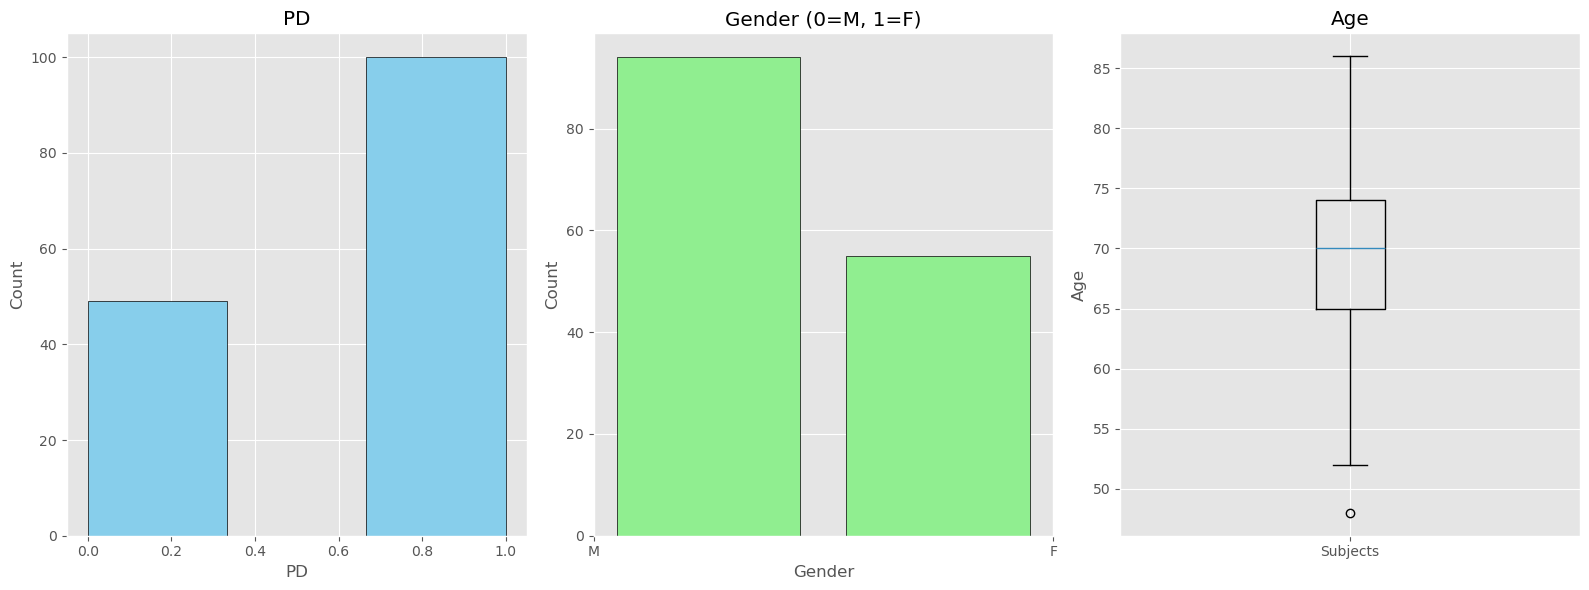

Expected Channels: 63. Subjects Differing: 30
Subjects per channel difference: {1: 29, 3: 1}


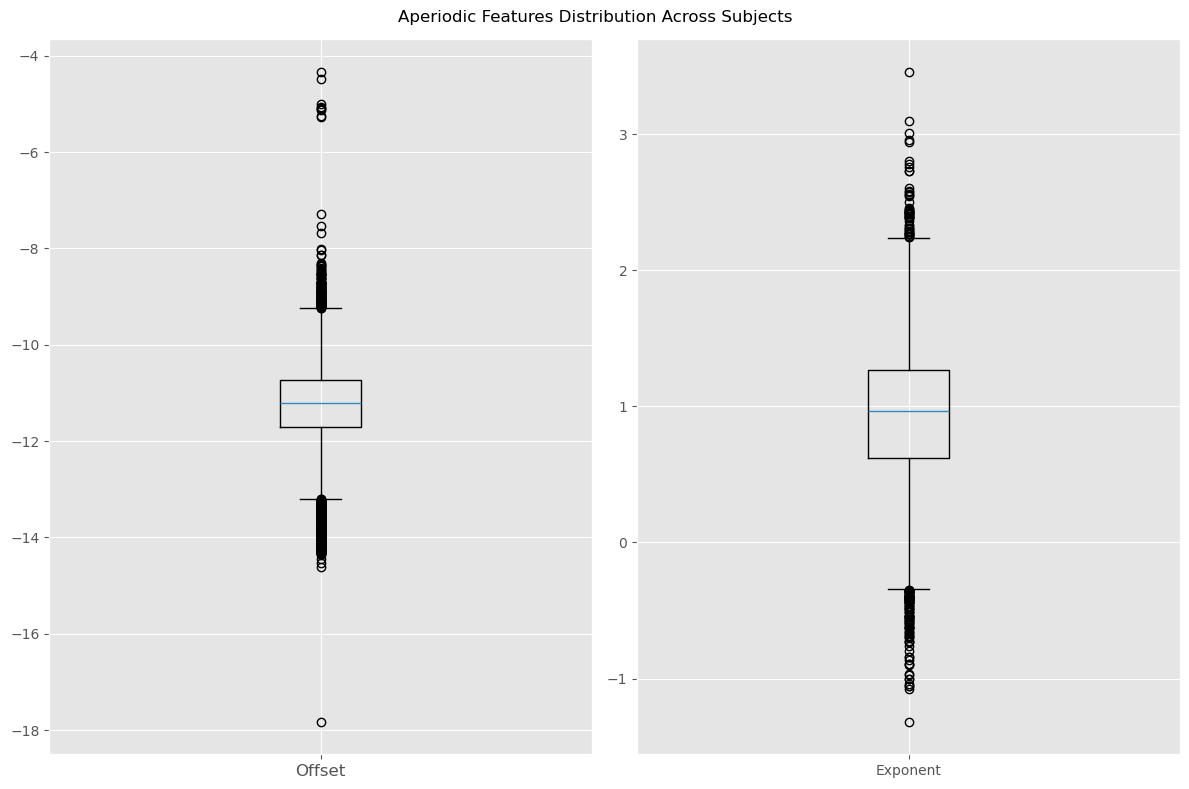

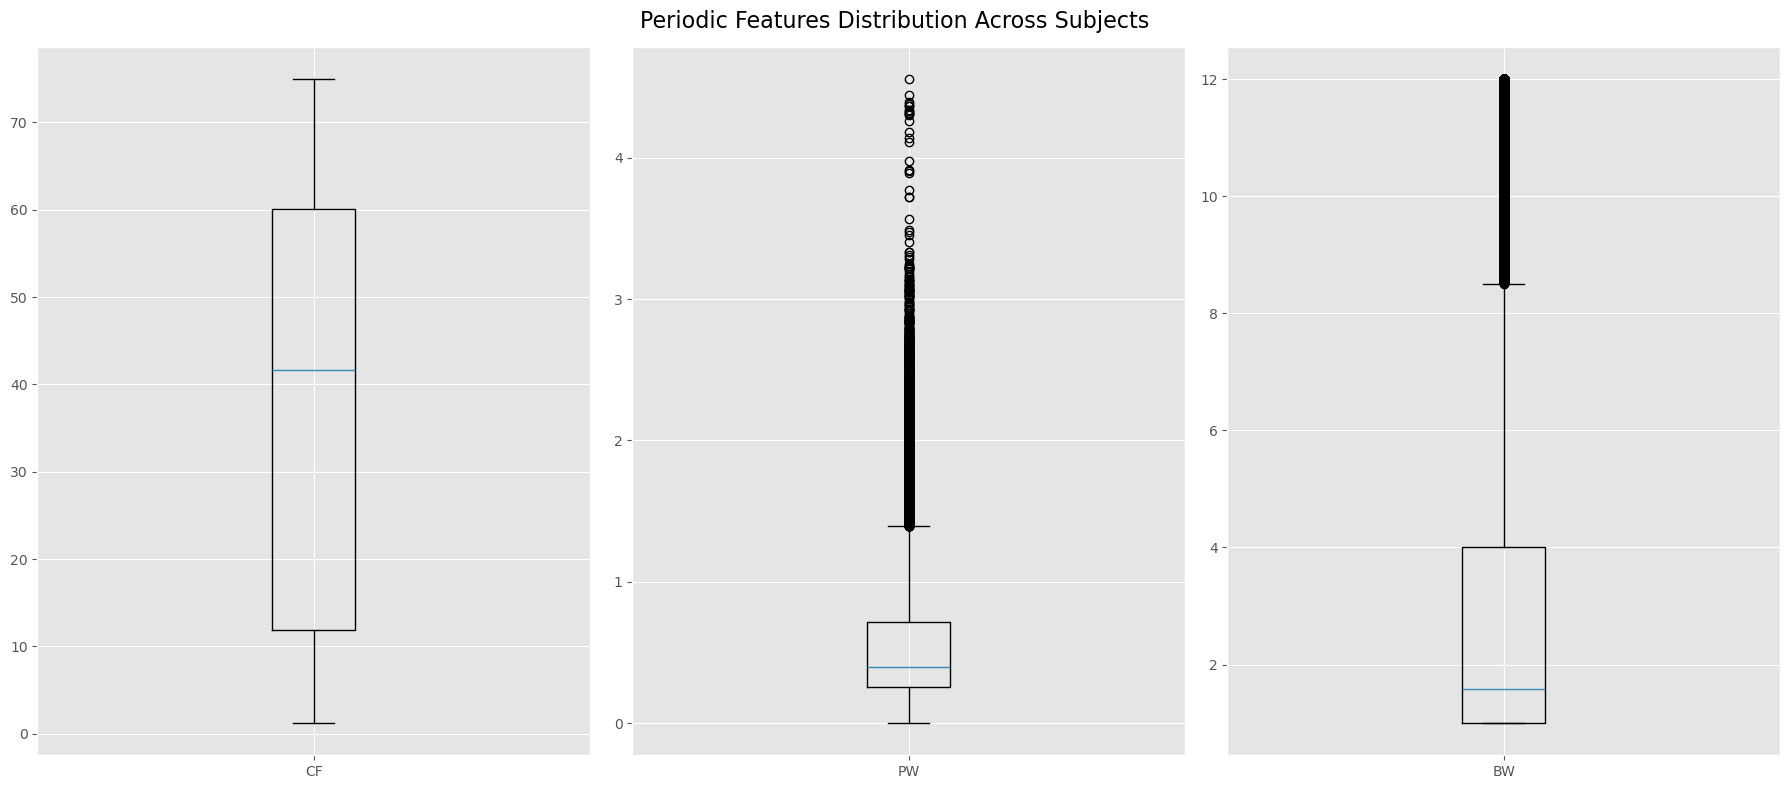

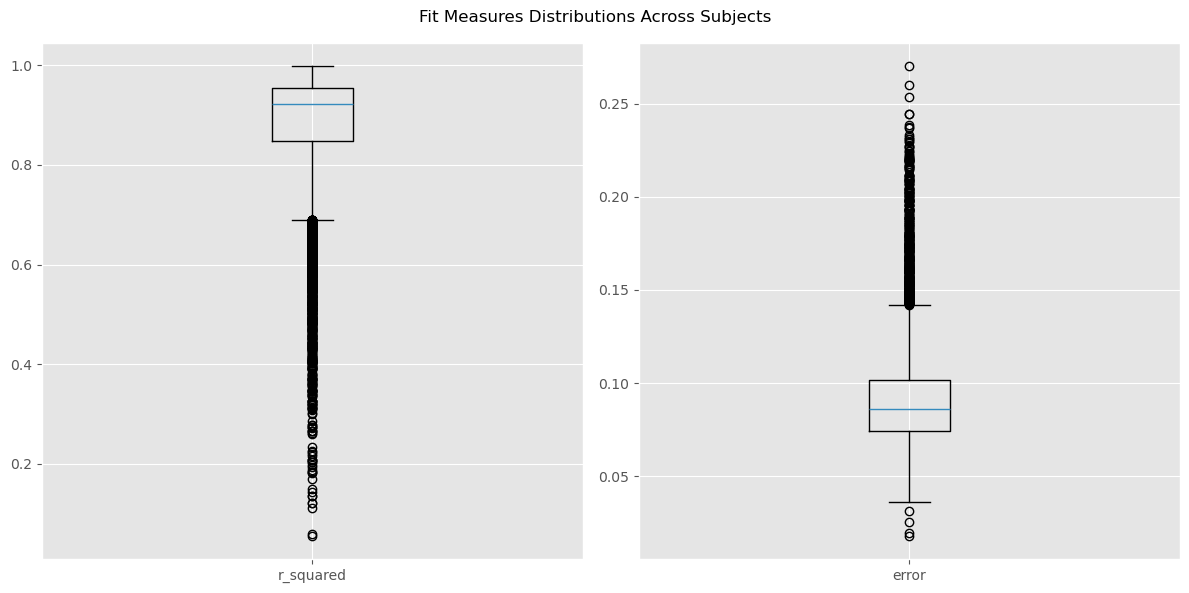

In [ ]:
# Load the EEG features superset
#

# Get features superset created after EEG processing
features_superset_df = pd.read_pickle(eeg_features_superset_file_path, compression='zip')

# Subject info distributions
subject_info_plot(features_superset_df)

# Check number of channels
channels_check(features_superset_df)

# Aperiodic and periodic components distributions
aperiodic_components_plot(features_superset_df)
periodic_components_plot(features_superset_df)
fit_error_plot(features_superset_df)



## xxxxx Data Cleaning